Starting training...
Step     0 | Total: 0.540583 | Energy: 0.540583 | Force: 0.380184 | wF: 0.00
Step   100 | Total: 0.058239 | Energy: 0.012413 | Force: 0.366608 | wF: 0.12
Step   200 | Total: 0.096022 | Energy: 0.005063 | Force: 0.363835 | wF: 0.25
Step   300 | Total: 0.139734 | Energy: 0.003575 | Force: 0.363089 | wF: 0.38
Step   400 | Total: 0.184057 | Energy: 0.002834 | Force: 0.362447 | wF: 0.50
Step   500 | Total: 0.228272 | Energy: 0.002267 | Force: 0.361608 | wF: 0.62
Step   600 | Total: 0.272549 | Energy: 0.001921 | Force: 0.360838 | wF: 0.75
Step   700 | Total: 0.316868 | Energy: 0.001696 | Force: 0.360196 | wF: 0.88
Step   800 | Total: 0.361164 | Energy: 0.001544 | Force: 0.359620 | wF: 1.00
Step   900 | Total: 0.405432 | Energy: 0.001489 | Force: 0.359060 | wF: 1.12
Step  1000 | Total: 0.449631 | Energy: 0.001515 | Force: 0.358492 | wF: 1.25
Step  1100 | Total: 0.493740 | Energy: 0.001621 | Force: 0.357905 | wF: 1.38
Step  1200 | Total: 0.537780 | Energy: 0.001817 | Force

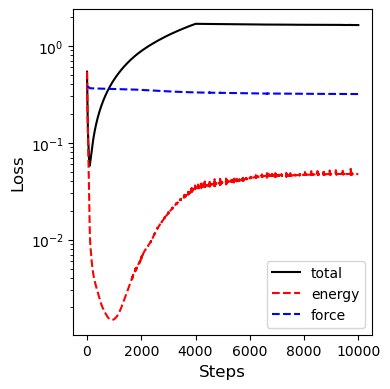

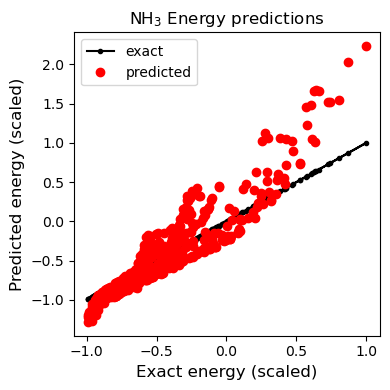

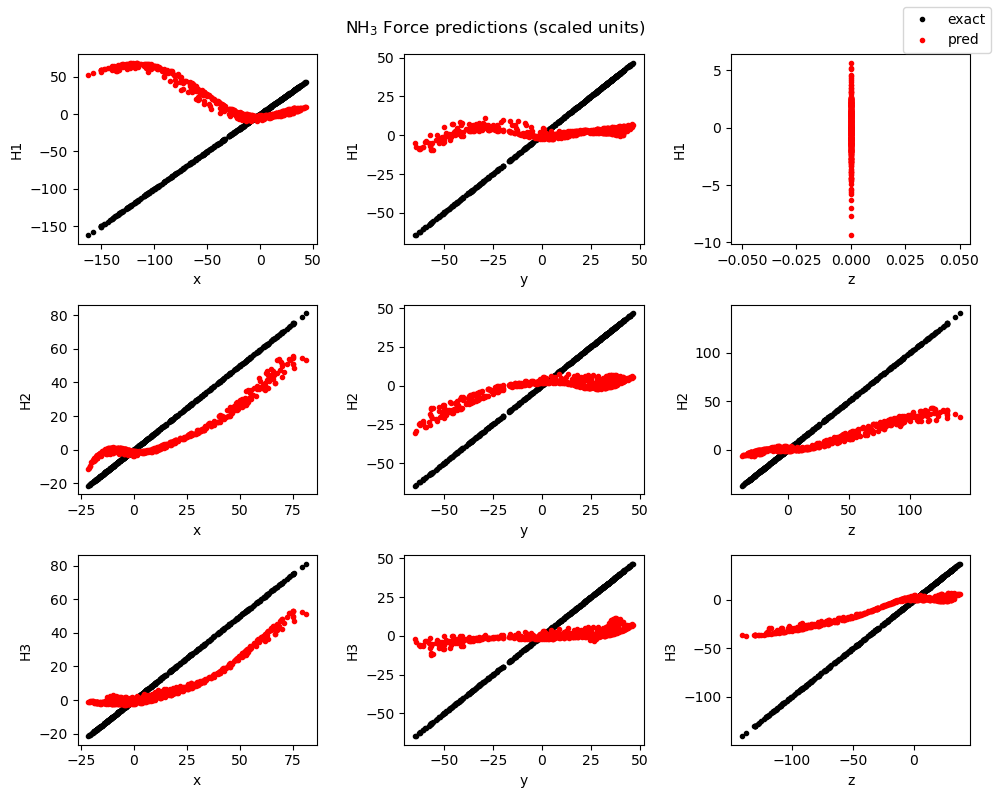

In [5]:
import pennylane as qml
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
from jax import numpy as jnp
from jax.example_libraries import optimizers
import matplotlib.pyplot as plt

# ================================================================
# 0. Small helper: Huber loss (for robust force loss)
# ================================================================
def huber(residual, delta=1.0):
    """Elementwise Huber loss."""
    abs_r = jnp.abs(residual)
    quad = 0.5 * residual**2
    lin  = delta * (abs_r - 0.5 * delta)
    return jnp.where(abs_r <= delta, quad, lin)

# ================================================================
# 1. EQNN-style building blocks
# ================================================================
def singlet(wires):
    """Two-qubit singlet state on given wire pair."""
    w0, w1 = wires
    qml.Hadamard(wires=w0)
    qml.PauliZ(wires=w0)
    qml.PauliX(wires=w1)
    qml.CNOT(wires=[w0, w1])

def equivariant_encoding(alpha, vec3, wires):
    """
    Equivariant encoding of a 3D vector on one qubit.

    axis = vec3 / ||vec3||
    angle = alpha * ||vec3||
    U ≈ Rot(angle * nx, angle * ny, angle * nz)
    """
    r = jnp.array(vec3, dtype=jnp.float64)
    norm = jnp.linalg.norm(r) + 1e-12
    n = r / norm
    theta = alpha * norm

    qml.Rot(theta * n[0], theta * n[1], theta * n[2], wires=wires[0])

def pair_layer(weight, wires):
    """Trainable 2-qubit 'Heisenberg-like' interaction via Ising gates."""
    qml.IsingXX(weight, wires=wires)
    qml.IsingYY(weight, wires=wires)
    qml.IsingZZ(weight, wires=wires)

# Observable on qubits (0,1)
observable = (
    qml.PauliX(0) @ qml.PauliX(1)
    + qml.PauliY(0) @ qml.PauliY(1)
    + qml.PauliZ(0) @ qml.PauliZ(1)
)

# ================================================================
# 2. Hyperparameters & device
# ================================================================
D = 6          # depth
rep = 2        # vertical repetition
active_atoms = 3  # H1, H2, H3 (N is fixed)
num_qubits   = active_atoms * rep  # 6

dev = qml.device("default.qubit", wires=num_qubits)

# ================================================================
# 3. QNode for EQNN energy model
# ================================================================
@qml.qnode(dev, interface="jax", diff_method="backprop")
def vqlm(coords, params):
    """
    coords: (3, 3) coords of H1,H2,H3 relative to N (one geometry).
    params["weights"]: (num_qubits, D)
    params["alphas"]:  (num_qubits, D+1)
    """
    weights = params["weights"]
    alphas  = params["alphas"]

    # Singlets on (0,1), (2,3), (4,5)
    for i in range(0, num_qubits - 1, 2):
        singlet([i, i + 1])

    # Initial encoding
    for i in range(num_qubits):
        equivariant_encoding(alphas[i, 0], coords[i % active_atoms], wires=[i])

    # D layers of pair interactions + re-encoding
    for d in range(D):
        qml.Barrier()

        # Even pairings
        for i in range(0, num_qubits - 1, 2):
            pair_layer(weights[i, d], wires=[i, (i + 1) % num_qubits])

        # Odd pairings
        for i in range(1, num_qubits, 2):
            pair_layer(weights[i, d], wires=[i, (i + 1) % num_qubits])

        # Re-encode geometry
        for i in range(num_qubits):
            equivariant_encoding(alphas[i, d + 1], coords[i % active_atoms], wires=[i])

    # Raw invariant scalar; a linear classical head will map this to energy
    return qml.expval(observable)

# Batched model over geometries
vec_vqlm = jax.vmap(vqlm, in_axes=(0, None), out_axes=0)

# ================================================================
# 4. Load NH3 dataset (already preprocessed by PSI4 script)
# ================================================================
energy    = np.load("eqnn_force_field_data_nh3_new/Energy.npy")    # (N,) scaled to [-1,1]
forces    = np.load("eqnn_force_field_data_nh3_new/Forces.npy")    # (N, 4, 3) scaled consistently
positions = np.load("eqnn_force_field_data_nh3_new/Positions.npy") # (N, 4, 3), N at origin

N_samples = energy.shape[0]

# N is at index 0, H1,H2,H3 are indices 1,2,3
positions_H = positions[:, 1:, :]   # (N, 3, 3)
forces_H    = forces[:, 1:, :]      # (N, 3, 3) in scaled units

energy_scaled = energy              # already scaled; no extra scaling

# ================================================================
# 5. Train / test split
# ================================================================
rng = np.random.default_rng(0)
indices = np.arange(N_samples)
rng.shuffle(indices)

n_train = int(0.8 * N_samples)
idx_train = indices[:n_train]
idx_test  = indices[n_train:]

data_train = jnp.array(positions_H[idx_train])  # (N_train, 3, 3)
data_test  = jnp.array(positions_H[idx_test])   # (N_test, 3, 3)

E_train = jnp.array(energy_scaled[idx_train])   # (N_train,)
E_test  = jnp.array(energy_scaled[idx_test])    # (N_test,)

F_train_scaled = jnp.array(forces_H[idx_train]) # (N_train, 3, 3)
F_test_scaled  = forces_H[idx_test]             # (N_test, 3, 3) for plotting

# ================================================================
# 6. Force RMS normalization (for loss only)
# ================================================================
F_rms = jnp.sqrt(jnp.mean(F_train_scaled**2)) + 1e-12
F_train_norm = F_train_scaled / F_rms

# ================================================================
# 7. Loss with linear head & robust force term
# ================================================================
# gradient of energy w.r.t. coordinates
grad_energy_single = jax.grad(lambda c, p: vqlm(c, p), argnums=0)
vec_grad = jax.vmap(grad_energy_single, in_axes=(0, None), out_axes=0)

def loss_fn(params, coords, E_target, F_target_norm, wE=1.0, wF=1.0):
    """
    params contains: "weights", "alphas", "head_scale", "head_bias"
    coords: (N, 3, 3)
    E_target: (N,) scaled
    F_target_norm: (N, 3, 3) forces normalized by F_rms
    """
    # raw quantum outputs
    raw_E = vec_vqlm(coords, params)       # (N,)
    raw_F = -vec_grad(coords, params)      # (N, 3, 3)

    scale = params["head_scale"]
    bias  = params["head_bias"]

    # linear head
    E_pred = scale * raw_E + bias          # (N,)
    F_pred_scaled = scale * raw_F          # (N, 3, 3) in scaled-force units

    # normalized forces for loss
    F_pred_norm = F_pred_scaled / F_rms

    # energy loss: MSE
    lE = jnp.mean((E_pred - E_target)**2)

    # robust force loss: Huber
    resid_F = F_pred_norm - F_target_norm
    lF = jnp.mean(huber(resid_F, delta=1.0))

    return wE * lE + wF * lF, (lE, lF)

# NOTE: Removed @jax.jit decorator to fix JAX tracer error with PennyLane
# The QNode with diff_method="backprop" handles differentiation internally
def train_step(step, opt_state, coords, E_target, F_target_norm, wE, wF):
    params = get_params(opt_state)

    def wrapped(p):
        total, comps = loss_fn(p, coords, E_target, F_target_norm, wE, wF)
        return total, comps

    (loss_val, (lE, lF)), grads = jax.value_and_grad(wrapped, has_aux=True)(params)
    new_state = opt_update(step, grads, opt_state)
    return loss_val, lE, lF, new_state

# ================================================================
# 8. Initialize parameters & optimizer
# ================================================================
np.random.seed(42)
weights0 = np.zeros((num_qubits, D), dtype=np.float64)
weights0[0] = np.random.uniform(0.0, np.pi, size=(D,))
weights = jnp.array(weights0)

alphas  = jnp.ones((num_qubits, D + 1), dtype=jnp.float64)

# linear head (scale & bias)
head_scale0 = jnp.array(1.0, dtype=jnp.float64)
head_bias0  = jnp.array(0.0, dtype=jnp.float64)

params0 = {
    "weights": weights,
    "alphas": alphas,
    "head_scale": head_scale0,
    "head_bias": head_bias0,
}

# slightly smaller learning rate for stability
opt_init, opt_update, get_params = optimizers.adam(3e-3)
opt_state = opt_init(params0)

# ================================================================
# 9. Training loop with force warmup
# ================================================================
num_steps = 10000
wE = 1.0
wF_max = 5.0    # final relative weight of force term
warmup = 4000   # steps to ramp wF from 0 → wF_max

history_total = []
history_E = []
history_F = []

print("Starting training...")
for step in range(num_steps):
    # curriculum: energy first, then forces matter more
    wF = wF_max * min(step / warmup, 1.0)

    loss_val, lE, lF, opt_state = train_step(
        step, opt_state, data_train, E_train, F_train_norm, wE, wF
    )

    history_total.append(float(loss_val))
    history_E.append(float(lE))
    history_F.append(float(lF))

    if step % 100 == 0:
        print(f"Step {step:5d} | Total: {loss_val:.6f} | Energy: {lE:.6f} | Force: {lF:.6f} | wF: {wF:.2f}")

print("Training complete!")

# ================================================================
# 10. Plot loss curves
# ================================================================
fontsize = 12
plt.figure(figsize=(4, 4))
plt.plot(history_total, "k-", label="total")
plt.plot(history_E, "r--", label="energy")
plt.plot(history_F, "b--", label="force")
plt.yscale("log")
plt.xlabel("Steps", fontsize=fontsize)
plt.ylabel("Loss", fontsize=fontsize)
plt.legend()
plt.tight_layout()
plt.savefig("loss_NH3.png", dpi=300)
plt.show()

# ================================================================
# 11. Energy predictions (with linear head)
# ================================================================
params = get_params(opt_state)
raw_E_test = np.array(vec_vqlm(data_test, params))
scale = float(params["head_scale"])
bias  = float(params["head_bias"])
E_pred_test = scale * raw_E_test + bias

plt.figure(figsize=(4, 4))
plt.title("NH$_3$ Energy predictions", fontsize=fontsize)
plt.plot(np.array(E_test), np.array(E_test), "k.-", label="exact")
plt.plot(np.array(E_test), E_pred_test, "ro", label="predicted")
plt.xlabel("Exact energy (scaled)", fontsize=fontsize)
plt.ylabel("Predicted energy (scaled)", fontsize=fontsize)
plt.legend()
plt.tight_layout()
plt.savefig("energy_NH3.png", dpi=300)
plt.show()

# ================================================================
# 12. Force predictions (scaled units)
# ================================================================
# recompute forces on the full dataset with trained params
raw_F_all = -vec_grad(jnp.array(positions_H), params)   # (N, 3, 3)
F_pred_all_scaled = np.array(scale * raw_F_all)         # apply head scale

F_pred_test_scaled = F_pred_all_scaled[idx_test]

fig, axs = plt.subplots(3, 3, figsize=(10, 8))
fig.suptitle("NH$_3$ Force predictions (scaled units)", fontsize=fontsize)

axis_labels = ["x", "y", "z"]
atom_labels = ["H1", "H2", "H3"]

for a in range(3):
    for c in range(3):
        ax = axs[a, c]
        # black: exact forces
        ax.plot(
            F_test_scaled[:, a, c],
            F_test_scaled[:, a, c],
            "k.",
            label="exact" if (a == 0 and c == 0) else None,
        )
        # red: predicted forces
        ax.plot(
            F_test_scaled[:, a, c],
            F_pred_test_scaled[:, a, c],
            "r.",
            label="pred" if (a == 0 and c == 0) else None,
        )
        ax.set_xlabel(axis_labels[c])
        ax.set_ylabel(atom_labels[a])

handles, labels = axs[0, 0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper right")

plt.tight_layout()
plt.savefig("force_NH3.png", dpi=300)
plt.show()

# The equivariant Code #


NH₃ - Graph-Based Equivariant QML
Strategy: Encode N-H bonds as graph edges, simple circuit

Data: 2400 configurations
Positions shape: (2400, 4, 3)
Forces shape: (2400, 4, 3)

Energy range: [-1.0000, 1.0000]
Energy scaled: [-1.0000, 1.0000]
Forces range: [-76.4454, 315.8943]
Forces scaled: [-1.0000, 1.0000]

Train: 1920, Test: 480

PHASE 1: Training ENERGY only

  Step    0 | Train: 18.360919 | Test: 17.084170 | GradNorm: 10.0000
  Step   25 | Train: 0.185423 | Test: 0.170699 | GradNorm: 0.5054
  Step   50 | Train: 0.185346 | Test: 0.173662 | GradNorm: 0.1881
  Step   75 | Train: 0.178023 | Test: 0.164224 | GradNorm: 0.1639
  Step  100 | Train: 0.169138 | Test: 0.160705 | GradNorm: 0.0814
  Step  125 | Train: 0.163714 | Test: 0.158668 | GradNorm: 0.0662
  Step  150 | Train: 0.159818 | Test: 0.156760 | GradNorm: 0.0657
  Step  175 | Train: 0.156252 | Test: 0.154157 | GradNorm: 0.0703
  Step  200 | Train: 0.152379 | Test: 0.150519 | GradNorm: 0.0754
  Step  225 | Train: 0.147924 | Test

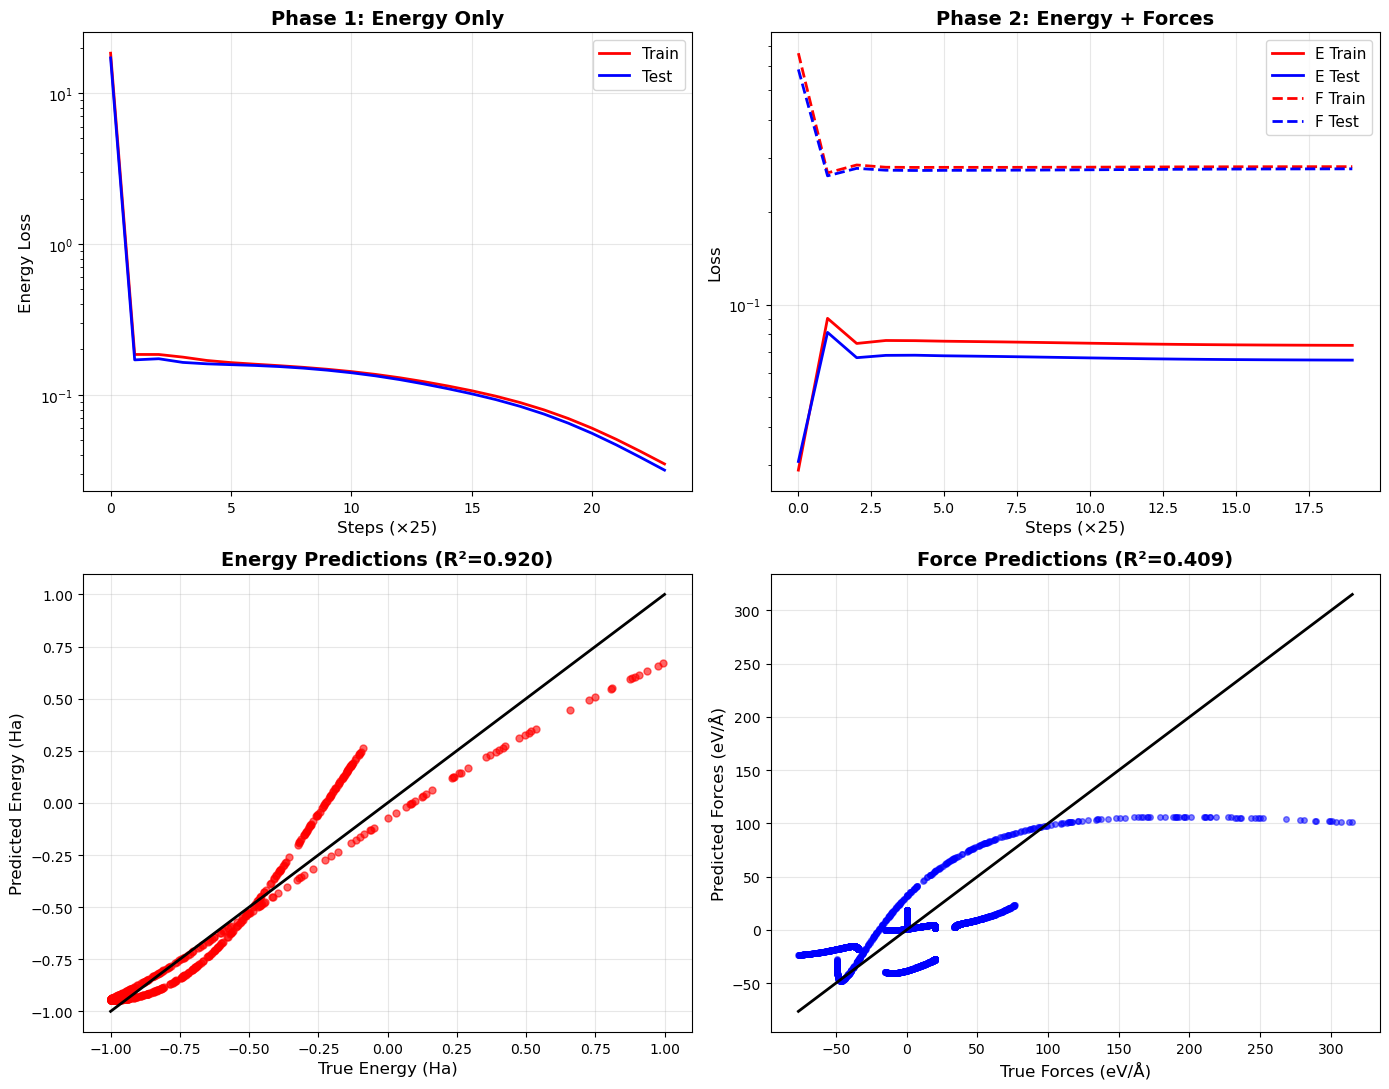

/tmp/ipykernel_389971/3272404387.py:463: RuntimeWarning: divide by zero encountered in scalar divide
  r2 = 1 - np.sum((F_pred_comp - F_true_comp)**2) / np.sum((F_true_comp - F_true_comp.mean())**2)


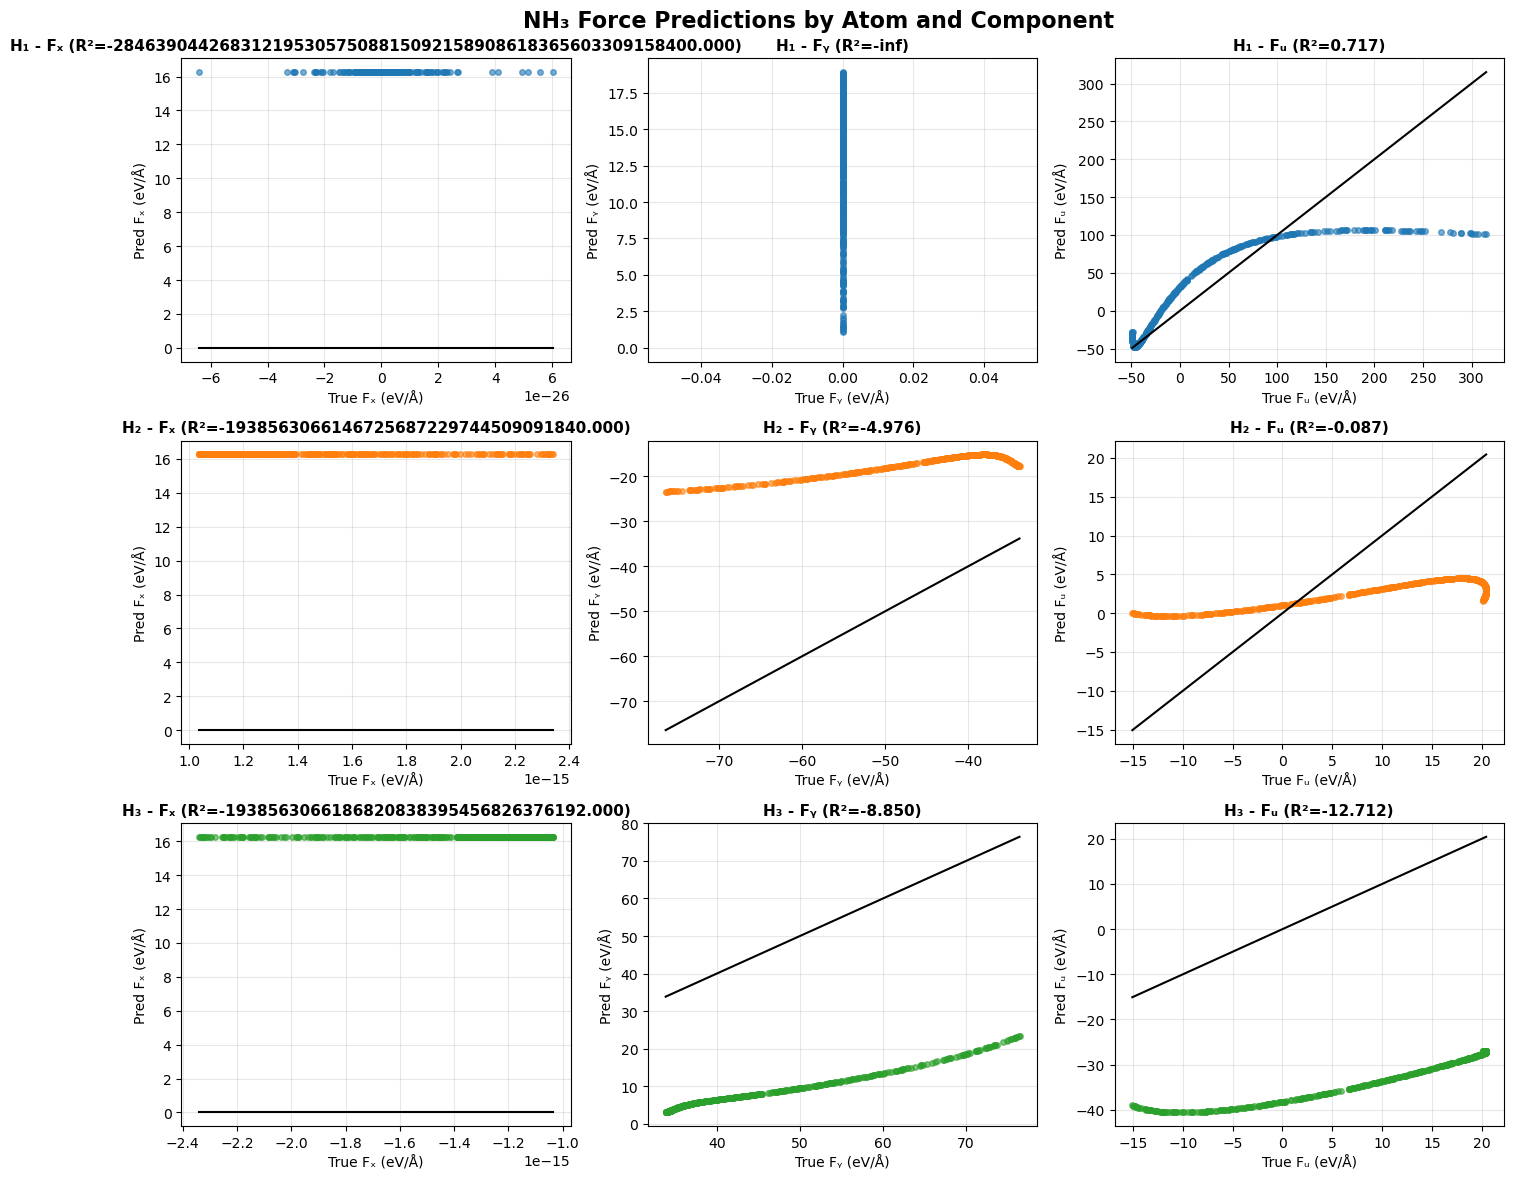


✓ Graph-based equivariant QML for NH₃ complete!
✓ Two-phase training: energy first, then forces
✓ Graph encoding: N-H bonds as edges with geometric features
✓ Predictions for all force components on all H atoms


In [4]:
import pennylane as qml
import numpy as np

import jax
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)

from jax import numpy as jnp
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

#############################################################################################
# GRAPH-BASED EQUIVARIANT QML FOR NH3
# Strategy: Encode molecular graph structure with N-H bonds
#############################################################################################

print(f"\n{'='*70}")
print(f"NH₃ - Graph-Based Equivariant QML")
print(f"{'='*70}")
print(f"Strategy: Encode N-H bonds as graph edges, simple circuit")
print(f"{'='*70}\n")

# NH3: 1 N atom + 3 H atoms = 4 atoms
# Graph structure: N at center, 3 edges to H atoms
# We'll use 6 qubits: 2 qubits per edge (N-H bond)

n_qubits = 6  # 3 bonds × 2 qubits per bond
depth = 4

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="jax", diff_method="backprop")
def graph_qnn(positions, params):
    """
    Graph-based QNN for NH3.
    positions: (4, 3) - [N, H1, H2, H3] coordinates
    
    Encodes the 3 N-H bonds as graph edges.
    Each bond gets 2 qubits.
    """
    weights = params["weights"]  # (depth, n_qubits, 3)
    
    # N is at index 0, H atoms at indices 1, 2, 3
    N_pos = positions[0]
    H_positions = positions[1:]  # (3, 3)
    
    # Compute 3 bond vectors and distances
    bonds = H_positions - N_pos[None, :]  # (3, 3)
    distances = jnp.linalg.norm(bonds, axis=1)  # (3,)
    
    # Compute angles between bonds (geometric features)
    # Angle between bond i and bond j
    def compute_angle(v1, v2):
        cos_angle = jnp.dot(v1, v2) / (jnp.linalg.norm(v1) * jnp.linalg.norm(v2) + 1e-12)
        return jnp.arccos(jnp.clip(cos_angle, -1.0, 1.0))
    
    angle_01 = compute_angle(bonds[0], bonds[1])
    angle_02 = compute_angle(bonds[0], bonds[2])
    angle_12 = compute_angle(bonds[1], bonds[2])
    
    # Initialize qubits - each pair represents a bond
    for i in range(n_qubits):
        qml.RY(0.5, wires=i)
    
    # Apply layers
    for layer in range(depth):
        # Encode bond distances on qubit pairs
        # Bond 0 (N-H1): qubits 0, 1
        qml.RY(weights[layer, 0, 0] * distances[0], wires=0)
        qml.RY(weights[layer, 1, 0] * distances[0], wires=1)
        
        # Bond 1 (N-H2): qubits 2, 3
        qml.RY(weights[layer, 2, 0] * distances[1], wires=2)
        qml.RY(weights[layer, 3, 0] * distances[1], wires=3)
        
        # Bond 2 (N-H3): qubits 4, 5
        qml.RY(weights[layer, 4, 0] * distances[2], wires=4)
        qml.RY(weights[layer, 5, 0] * distances[2], wires=5)
        
        # Entangle within bonds
        qml.CNOT(wires=[0, 1])
        qml.CNOT(wires=[2, 3])
        qml.CNOT(wires=[4, 5])
        
        # Encode angular information (cross-bond interactions)
        qml.RZ(weights[layer, 0, 1] * angle_01, wires=0)
        qml.RZ(weights[layer, 2, 1] * angle_01, wires=2)
        
        qml.RZ(weights[layer, 0, 2] * angle_02, wires=0)
        qml.RZ(weights[layer, 4, 2] * angle_02, wires=4)
        
        qml.RZ(weights[layer, 2, 2] * angle_12, wires=2)
        qml.RZ(weights[layer, 4, 2] * angle_12, wires=4)
        
        # Cross-bond entanglement (graph connectivity)
        qml.CNOT(wires=[1, 2])  # Connect bond 0 to bond 1
        qml.CNOT(wires=[3, 4])  # Connect bond 1 to bond 2
        qml.CNOT(wires=[5, 0])  # Connect bond 2 to bond 0 (cyclic)
        
        # Additional rotations
        for i in range(n_qubits):
            qml.RZ(weights[layer, i, 1], wires=i)
            qml.RY(weights[layer, i, 2], wires=i)
    
    # Measure all qubits and combine
    return qml.expval(qml.sum(*(qml.PauliZ(i) for i in range(n_qubits))))

#############################################################################################
# DATA LOADING
#############################################################################################

energy = np.load("eqnn_force_field_data_nh3/Energy.npy")
forces = np.load("eqnn_force_field_data_nh3/Forces.npy")
positions = np.load("eqnn_force_field_data_nh3/Positions.npy")

print(f"Data: {len(positions)} configurations")
print(f"Positions shape: {positions.shape}")
print(f"Forces shape: {forces.shape}\n")

# Normalize energies
energy_scaler = MinMaxScaler((-1, 1))
if energy.ndim == 1:
    energy = energy.reshape(-1, 1)
energy_scaled = energy_scaler.fit_transform(energy).flatten()

# Normalize forces (all components for all H atoms)
forces_H = forces[:, 1:, :]  # (N, 3, 3) - forces on 3 H atoms
force_scaler = MinMaxScaler((-1, 1))

# Flatten forces for scaling
forces_flat = forces_H.reshape(-1, 1)
forces_scaled_flat = force_scaler.fit_transform(forces_flat).flatten()
forces_scaled = forces_scaled_flat.reshape(forces_H.shape)

print(f"Energy range: [{energy.min():.4f}, {energy.max():.4f}]")
print(f"Energy scaled: [{energy_scaled.min():.4f}, {energy_scaled.max():.4f}]")
print(f"Forces range: [{forces_H.min():.4f}, {forces_H.max():.4f}]")
print(f"Forces scaled: [{forces_scaled.min():.4f}, {forces_scaled.max():.4f}]\n")

# Train/test split
np.random.seed(42)
indices_train = np.random.choice(len(positions), size=int(0.8 * len(positions)), replace=False)
indices_test = np.setdiff1d(np.arange(len(positions)), indices_train)

E_train = energy_scaled[indices_train]
E_test = energy_scaled[indices_test]
F_train = forces_scaled[indices_train]  # (N_train, 3, 3)
F_test = forces_scaled[indices_test]    # (N_test, 3, 3)
pos_train = jnp.array(positions[indices_train])
pos_test = jnp.array(positions[indices_test])

print(f"Train: {len(indices_train)}, Test: {len(indices_test)}\n")

#############################################################################################
# PHASE 1: ENERGY ONLY
#############################################################################################

from jax.example_libraries import optimizers

vec_qnn = jax.vmap(graph_qnn, (0, None), 0)

@jax.jit
def energy_loss(params, loss_data):
    positions, E_target = loss_data
    E_pred = vec_qnn(positions, params)
    return jnp.mean((E_pred - E_target) ** 2)

def train_step_energy(step_i, opt_state, loss_data):
    net_params = get_params(opt_state)
    loss, grads = jax.value_and_grad(energy_loss)(net_params, loss_data)
    
    # Check gradient health
    grad_norm = jnp.sqrt(sum(jnp.sum(jnp.square(g)) for g in jax.tree.leaves(grads) if g is not None))
    
    # Gradient clipping
    if grad_norm > 10.0:
        grads = jax.tree.map(lambda g: g * (10.0 / grad_norm) if g is not None else g, grads)
        grad_norm = 10.0
    
    return float(loss), float(grad_norm), opt_update(step_i, grads, opt_state)

# Initialize parameters
np.random.seed(42)
weights = jnp.array(np.random.normal(0, 0.1, (depth, n_qubits, 3)))
net_params = {"weights": weights}

print(f"{'='*70}")
print(f"PHASE 1: Training ENERGY only")
print(f"{'='*70}\n")

lr = 0.01
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(net_params)

energy_losses = []

for step in range(600):
    loss_data = (pos_train, E_train)
    loss, grad_norm, opt_state = train_step_energy(step, opt_state, loss_data)
    
    if step % 25 == 0:
        # Test loss
        test_params = get_params(opt_state)
        E_pred_test = np.array(vec_qnn(pos_test, test_params))
        test_loss = np.mean((E_pred_test - E_test) ** 2)
        
        energy_losses.append([loss, test_loss])
        
        print(f"  Step {step:4d} | Train: {loss:.6f} | Test: {test_loss:.6f} | GradNorm: {grad_norm:.4f}")

print(f"\nEnergy training complete!\n")

# Get trained parameters
trained_params = get_params(opt_state)

# Predictions
E_pred_train = np.array(vec_qnn(pos_train, trained_params))
E_pred_test = np.array(vec_qnn(pos_test, trained_params))

E_train_r2 = 1 - np.var(E_pred_train - E_train) / np.var(E_train)
E_test_r2 = 1 - np.var(E_pred_test - E_test) / np.var(E_test)

print(f"Energy R² (train): {E_train_r2:.4f}")
print(f"Energy R² (test):  {E_test_r2:.4f}\n")

#############################################################################################
# PHASE 2: ADD FORCES
#############################################################################################

print(f"{'='*70}")
print(f"PHASE 2: Adding FORCES")
print(f"{'='*70}\n")

def energy_single(coords, params):
    return graph_qnn(coords, params)

def force_single(coords, params):
    """Compute forces as negative gradient of energy w.r.t. positions."""
    grad_fn = jax.grad(energy_single, argnums=0)
    gradient = grad_fn(coords, params)
    return -gradient

vec_force = jax.vmap(force_single, (0, None), 0)

@jax.jit
def combined_loss(params, loss_data):
    positions, E_target, F_target = loss_data
    
    # Energy loss
    E_pred = vec_qnn(positions, params)
    E_loss = jnp.mean((E_pred - E_target) ** 2)
    
    # Force loss - predict forces on H atoms
    F_pred_full = vec_force(positions, params)  # (N, 4, 3)
    F_pred_H = F_pred_full[:, 1:, :]  # (N, 3, 3) - only H atoms
    
    # MSE on all force components
    F_loss = jnp.mean((F_pred_H - F_target) ** 2)
    
    # Check for NaN
    E_loss = jnp.where(jnp.isnan(E_loss), 1.0, E_loss)
    F_loss = jnp.where(jnp.isnan(F_loss), 1.0, F_loss)
    
    # Weighted combination - energy-dominant initially
    lambda_E = 2.0
    lambda_F = 1.0
    
    total_loss = lambda_E * E_loss + lambda_F * F_loss
    
    return total_loss, (E_loss, F_loss)

def train_step_combined(step_i, opt_state, loss_data):
    net_params = get_params(opt_state)
    (loss, (E_loss, F_loss)), grads = jax.value_and_grad(combined_loss, has_aux=True)(net_params, loss_data)
    
    # Gradient norm
    grad_norm = jnp.sqrt(sum(jnp.sum(jnp.square(g)) for g in jax.tree.leaves(grads) if g is not None))
    
    # Gradient clipping
    if grad_norm > 10.0:
        grads = jax.tree.map(lambda g: g * (10.0 / grad_norm) if g is not None else g, grads)
        grad_norm = 10.0
    
    return float(loss), float(E_loss), float(F_loss), float(grad_norm), opt_update(step_i, grads, opt_state)

# Start from trained energy parameters
opt_state = opt_init(trained_params)

combined_losses = []

print("Training with energy + forces:")
for step in range(500):
    loss_data = (pos_train, E_train, F_train)
    loss, E_loss, F_loss, grad_norm, opt_state = train_step_combined(step, opt_state, loss_data)
    
    if step % 25 == 0:
        # Test
        test_params = get_params(opt_state)
        E_pred_test_val = np.array(vec_qnn(pos_test, test_params))
        F_pred_test_val = np.array(vec_force(pos_test, test_params))[:, 1:, :]
        
        E_test_loss = np.mean((E_pred_test_val - E_test) ** 2)
        F_test_loss = np.mean((F_pred_test_val - F_test) ** 2)
        
        combined_losses.append([E_loss, E_test_loss, F_loss, F_test_loss])
        
        print(f"  Step {step:4d} | E: {E_loss:.4f}/{E_test_loss:.4f} | "
              f"F: {F_loss:.4f}/{F_test_loss:.4f} | GradNorm: {grad_norm:.4f}")

print(f"\n{'='*70}")
print("Training complete!")
print(f"{'='*70}\n")

#############################################################################################
# FINAL EVALUATION
#############################################################################################

final_params = get_params(opt_state)

# Predictions on all data
E_pred_all = np.array(vec_qnn(jnp.array(positions), final_params))
F_pred_all = np.array(vec_force(jnp.array(positions), final_params))
F_pred_all_H = F_pred_all[:, 1:, :]  # (N, 3, 3)

# Post-correction for energy
print("Post-correction...")

def corr_E(E, a, b, c):
    return a * E**2 + b * E + c

try:
    popt_E, _ = curve_fit(corr_E, E_pred_all[indices_train], E_train)
    E_pred_corr = corr_E(E_pred_all, *popt_E)
    print(f"Energy: a={popt_E[0]:.4f}, b={popt_E[1]:.4f}, c={popt_E[2]:.4f}")
except:
    E_pred_corr = E_pred_all
    print("Energy: No correction applied")

# Post-correction for forces (linear)
try:
    F_pred_flat = F_pred_all_H[indices_train].flatten().reshape(-1, 1)
    F_true_flat = F_train.flatten().reshape(-1, 1)
    
    lr_model = LinearRegression()
    lr_model.fit(F_pred_flat, F_true_flat)
    
    F_pred_all_flat = F_pred_all_H.reshape(-1, 1)
    F_pred_corr_flat = lr_model.predict(F_pred_all_flat)
    F_pred_corr = F_pred_corr_flat.reshape(F_pred_all_H.shape)
    
    print(f"Force: slope={lr_model.coef_[0][0]:.4f}, intercept={lr_model.intercept_[0]:.4f}")
except:
    F_pred_corr = F_pred_all_H
    print("Force: No correction applied")

# Inverse transform to original units
E_pred_final = energy_scaler.inverse_transform(E_pred_corr.reshape(-1, 1)).flatten()
E_true = energy_scaler.inverse_transform(energy_scaled.reshape(-1, 1)).flatten()

F_pred_corr_flat = F_pred_corr.reshape(-1, 1)
F_pred_final_flat = force_scaler.inverse_transform(F_pred_corr_flat)
F_pred_final = F_pred_final_flat.reshape(F_pred_corr.shape)

F_true = forces[:, 1:, :]  # Original forces on H atoms

# Compute metrics
E_mae = np.mean(np.abs(E_pred_final[indices_test] - E_true[indices_test]))
E_rmse = np.sqrt(np.mean((E_pred_final[indices_test] - E_true[indices_test]) ** 2))
E_r2 = 1 - np.sum((E_pred_final[indices_test] - E_true[indices_test])**2) / np.sum((E_true[indices_test] - E_true[indices_test].mean())**2)

F_test_true = F_true[indices_test].flatten()
F_test_pred = F_pred_final[indices_test].flatten()

F_mae = np.mean(np.abs(F_test_pred - F_test_true))
F_rmse = np.sqrt(np.mean((F_test_pred - F_test_true) ** 2))
F_r2 = 1 - np.sum((F_test_pred - F_test_true)**2) / np.sum((F_test_true - F_test_true.mean())**2)

print(f"\n{'='*70}")
print(f"FINAL RESULTS")
print(f"{'='*70}")
print(f"Energy:")
print(f"  MAE:  {E_mae:.6f} Ha ({E_mae*27.2114:.3f} eV)")
print(f"  RMSE: {E_rmse:.6f} Ha ({E_rmse*27.2114:.3f} eV)")
print(f"  R²:   {E_r2:.4f}")
print(f"\nForces (all components, all H atoms):")
print(f"  MAE:  {F_mae:.4f} eV/Å")
print(f"  RMSE: {F_rmse:.4f} eV/Å")
print(f"  R²:   {F_r2:.4f}")
print(f"{'='*70}\n")

#############################################################################################
# PLOTS
#############################################################################################

fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# Energy training (Phase 1)
energy_losses = np.array(energy_losses)
axes[0, 0].plot(energy_losses[:, 0], 'r-', lw=2, label='Train')
axes[0, 0].plot(energy_losses[:, 1], 'b-', lw=2, label='Test')
axes[0, 0].set_yscale('log')
axes[0, 0].set_xlabel('Steps (×25)', fontsize=12)
axes[0, 0].set_ylabel('Energy Loss', fontsize=12)
axes[0, 0].set_title('Phase 1: Energy Only', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Combined training (Phase 2)
if len(combined_losses) > 0:
    combined_losses = np.array(combined_losses)
    axes[0, 1].plot(combined_losses[:, 0], 'r-', lw=2, label='E Train')
    axes[0, 1].plot(combined_losses[:, 1], 'b-', lw=2, label='E Test')
    axes[0, 1].plot(combined_losses[:, 2], 'r--', lw=2, label='F Train')
    axes[0, 1].plot(combined_losses[:, 3], 'b--', lw=2, label='F Test')
    axes[0, 1].set_yscale('log')
    axes[0, 1].set_xlabel('Steps (×25)', fontsize=12)
    axes[0, 1].set_ylabel('Loss', fontsize=12)
    axes[0, 1].set_title('Phase 2: Energy + Forces', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)

# Energy predictions
axes[1, 0].plot(E_true[indices_test], E_pred_final[indices_test], 'ro', alpha=0.6, ms=5)
axes[1, 0].plot([E_true.min(), E_true.max()], [E_true.min(), E_true.max()], 'k-', lw=2)
axes[1, 0].set_xlabel('True Energy (Ha)', fontsize=12)
axes[1, 0].set_ylabel('Predicted Energy (Ha)', fontsize=12)
axes[1, 0].set_title(f'Energy Predictions (R²={E_r2:.3f})', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Force predictions
axes[1, 1].plot(F_test_true, F_test_pred, 'bo', alpha=0.5, ms=4)
axes[1, 1].plot([F_test_true.min(), F_test_true.max()], 
                [F_test_true.min(), F_test_true.max()], 'k-', lw=2)
axes[1, 1].set_xlabel('True Forces (eV/Å)', fontsize=12)
axes[1, 1].set_ylabel('Predicted Forces (eV/Å)', fontsize=12)
axes[1, 1].set_title(f'Force Predictions (R²={F_r2:.3f})', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('NH3_graph_eqnn.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional plot: Force components per atom
fig, axes = plt.subplots(3, 3, figsize=(14, 12))
fig.suptitle('NH₃ Force Predictions by Atom and Component', fontsize=16, fontweight='bold')

atom_names = ['H₁', 'H₂', 'H₃']
component_names = ['Fₓ', 'Fᵧ', 'Fᵤ']

for atom_idx in range(3):
    for comp_idx in range(3):
        ax = axes[atom_idx, comp_idx]
        
        F_true_comp = F_true[indices_test, atom_idx, comp_idx]
        F_pred_comp = F_pred_final[indices_test, atom_idx, comp_idx]
        
        ax.plot(F_true_comp, F_pred_comp, 'o', alpha=0.6, ms=4, color=f'C{atom_idx}')
        ax.plot([F_true_comp.min(), F_true_comp.max()], 
                [F_true_comp.min(), F_true_comp.max()], 'k-', lw=1.5)
        
        r2 = 1 - np.sum((F_pred_comp - F_true_comp)**2) / np.sum((F_true_comp - F_true_comp.mean())**2)
        
        ax.set_xlabel(f'True {component_names[comp_idx]} (eV/Å)', fontsize=10)
        ax.set_ylabel(f'Pred {component_names[comp_idx]} (eV/Å)', fontsize=10)
        ax.set_title(f'{atom_names[atom_idx]} - {component_names[comp_idx]} (R²={r2:.3f})', 
                    fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('NH3_force_components.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Graph-based equivariant QML for NH₃ complete!")
print("✓ Two-phase training: energy first, then forces")
print("✓ Graph encoding: N-H bonds as edges with geometric features")
print("✓ Predictions for all force components on all H atoms")